# Shapley effects for the Rust Model

In [82]:
# Import statements as in simulation_convergence.ipynb.
import matplotlib.pyplot as plt
#import yaml
import numpy as np
from ruspy.simulation.simulation import simulate
from ruspy.model_code.fix_point_alg import calc_fixp
from ruspy.model_code.cost_functions import lin_cost
from ruspy.model_code.cost_functions import calc_obs_costs
from ruspy.estimation.estimation_transitions import create_transition_matrix

# Additional imports from get_demand module.
from ruspy.estimation.estimation_interface import select_model_parameters
from ruspy.model_code.choice_probabilities import choice_prob_gumbel

# Additional import from tutorial uncertainty propagation.
import matplotlib as mpl

# My imports.
import chaospy as cp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from ruspy.estimation.estimation import estimate
from ruspy.model_code.demand_function import get_demand
from python.econsa_shapley import get_shapley

## Understand simulation capabilities of `ruspy`
The below code is taken from the notebook simulation_convergence provided as promotional material for `ruspy`.

In [2]:
# Set simulating variables
disc_fac = 0.9999
num_buses = 50
num_periods = 120
gridsize = 1000
# We use the cost parameters and transition probabilities from the replication
params = np.array([10.07780762, 2.29417622])
trans_probs = np.array([0.39189182, 0.59529371, 0.01281447])
scale = 1e-3

init_dict_sim = {
    "simulation": {
        "discount_factor": disc_fac,
        "periods": num_periods,
        "seed": 123,
        "buses": num_buses,
    },
    "plot": {"gridsize": gridsize},
}

In [3]:
# Calucalte objects necessary for the simulation process. See documentation for details.
num_states = 200
costs = calc_obs_costs(num_states, lin_cost, params, scale)

trans_mat = create_transition_matrix(num_states, trans_probs)
ev = calc_fixp(trans_mat, costs, disc_fac)[0]

In [4]:
# Can use one init_dict for get_demand() and estimate().
init_dict_estimation = {
    'model_specifications': {
        'discount_factor': disc_fac,
        'number_states': num_states,
        'maint_cost_func': 'linear',
        'cost_scale': 1e-3
    },
    'optimizer': {
        'approach': 'NFXP',
        'algorithm': 'scipy_L-BFGS-B',
        'gradient': 'Yes'
    },
    
}

In [5]:
%%time

# Define number of simulations.
num_sim = 100

# Initialize array to save parameter estimates.
parameter_estimates = np.zeros((num_sim, len(trans_probs) + len(params) -1))

for i in np.arange(num_sim):
    
    init_dict_sim['simulation']['seed'] = +i
    
    df = simulate(init_dict_sim["simulation"], ev, costs, trans_mat)
    data = df[['state', 'decision', 'usage']].copy()
    
    result_transitions_nfxp, result_fixp_nfxp = estimate(init_dict_estimation, data)
    
    # Record only two of three transition probabilities i.o.t. avoid singularity of the covariance matrix.
    parameter_estimates[i, :] = np.concatenate((result_transitions_nfxp['x'][:2], result_fixp_nfxp['x']))

Wall time: 4min 33s


In [6]:
cov = np.cov(parameter_estimates.T)

In [7]:
mean = np.mean(parameter_estimates, axis=0)

In [8]:
distribution = cp.MvNormal(mean, cov)
parameter_samples = pd.DataFrame(data=(distribution.sample(1000).T),
                                 columns=('t_30', 't_31', 'RC', 't_11'),
                                )

In [9]:
parameter_samples

,t_30,t_31,RC,t_11
0,0.396667,0.591867,11.238178,2.733353
1,0.384778,0.600740,6.455390,1.250078
2,0.379826,0.608713,8.532692,1.513996
3,0.404034,0.580344,9.673084,2.034186
4,0.393743,0.591214,9.142665,1.391308
...,...,...,...,...
995,0.387117,0.599726,10.328949,2.161428
996,0.400130,0.587388,9.950047,2.330865
997,0.397502,0.590932,8.651674,1.654523
998,0.384218,0.600816,10.344375,2.042824


In [10]:
# Add third transition probability: t_32 = 1 - t_30 - t_31
parameter_samples['t_32'] = 1 - parameter_samples['t_30'] - parameter_samples['t_31']

In [11]:
parameter_samples

,t_30,t_31,RC,t_11,t_32
0,0.396667,0.591867,11.238178,2.733353,0.011467
1,0.384778,0.600740,6.455390,1.250078,0.014482
2,0.379826,0.608713,8.532692,1.513996,0.011461
3,0.404034,0.580344,9.673084,2.034186,0.015622
4,0.393743,0.591214,9.142665,1.391308,0.015043
...,...,...,...,...,...
995,0.387117,0.599726,10.328949,2.161428,0.013157
996,0.400130,0.587388,9.950047,2.330865,0.012482
997,0.397502,0.590932,8.651674,1.654523,0.011566
998,0.384218,0.600816,10.344375,2.042824,0.014965


In [26]:
# Plot distributions.
#sns.jointplot(data=parameter_samples, x='RC', y='t_11')

In [27]:
# Plot distributions.
#sns.displot(parameter_samples, x='RC', y='t_11')

In [33]:
# Plot distributions.
#sns.pairplot(parameter_samples)

### Calculate demand level from structural parameter estimates

In [64]:
# Sample data.
n_sim_demand = 100
input_variables = cp.MvNormal(mean, cov).sample(n_sim_demand).T

In [66]:
#input_variables

In [67]:
n_inputs = 5
inputs = np.zeros((n_sim_demand, n_inputs))

In [68]:
# Fill the inputs array.
inputs[:,:2] = input_variables[:,:2]
# At third position insert thrid transition probability.
inputs[:, 2] = 1 - input_variables[:, 0] - input_variables[:, 1]
inputs[:, 3:] = input_variables[:, 2:]

In [70]:
#inputs

In [46]:
# Need demand at certain value of RC only.
demand_dict = {
    "RC_lower_bound": 4,
    "RC_upper_bound": 13,
    "demand_evaluations": 100,
    "tolerance": 1e-10,
    "num_periods": num_periods,
    "num_buses": num_buses,
}
demand_params = inputs[0, :]

In [47]:
#demand = get_demand(init_dict_estimation, demand_dict, demand_params)
#demand.head()

,demand,success
RC,,
4.000000,205.126,Yes
4.090909,196.64,Yes
4.181818,188.777,Yes
4.272727,181.481,Yes
4.363636,174.703,Yes


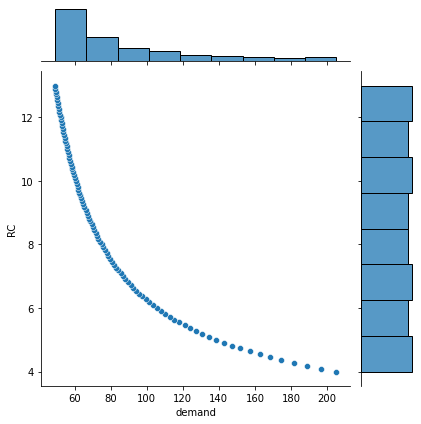

In [51]:
#sns.jointplot(data=demand, x='demand', y='RC')

Text(0, 0.5, 'Expected Implied Annual Demand')

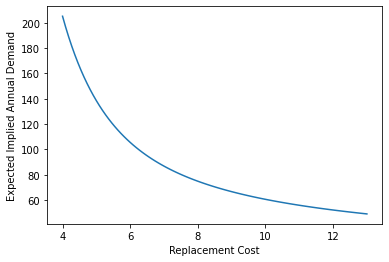

In [52]:
#plt.plot(demand.index.to_numpy(), demand["demand"].astype(float).to_numpy())
#plt.xlabel("Replacement Cost")
#plt.ylabel("Expected Implied Annual Demand")

### Demand at certain value of RC. 

In [71]:
# Need demand at certain value of RC only.
demand_dict = {
    "RC_lower_bound": 11.5,
    "RC_upper_bound": 11.5,
    "demand_evaluations": 1,
    "tolerance": 1e-10,
    "num_periods": num_periods,
    "num_buses": num_buses,
}

In [72]:
# Intitialize for loop for calculating implied demand for input samples.
implied_demand = np.zeros(n_sim_demand)
for sample in np.arange(n_sim_demand):
    demand_params = inputs[sample, :]
    demand = get_demand(init_dict_estimation, demand_dict, demand_params)
    implied_demand[sample] = demand.iloc[0][0]

In [88]:
np.sort(implied_demand)

array([10.18789957, 34.02146982, 43.12110883, 43.56098432, 46.58018323,
       47.43989192, 48.31628609, 49.06046724, 49.12257827, 49.60174538,
       49.93578256, 50.65042433, 50.69043733, 50.7609064 , 51.86430545,
       51.88834625, 52.56559329, 52.88341108, 53.50701247, 53.73617829,
       54.5221248 , 54.83506097, 54.94573853, 54.94728115, 55.26053535,
       55.5714561 , 56.05696913, 56.14267839, 56.38981057, 56.58341467,
       56.6228418 , 56.69262082, 56.8356587 , 57.81364794, 57.82768359,
       58.09823404, 58.2642117 , 58.31694421, 58.41132998, 58.5060924 ,
       58.79302327, 58.99832114, 59.64393482, 59.64965245, 59.99349178,
       60.05570592, 60.07538059, 60.1485948 , 60.1586717 , 60.64341302,
       60.71627908, 61.12343011, 61.1489739 , 61.1915544 , 61.22175897,
       61.74465589, 61.82424028, 62.4207824 , 62.6765352 , 62.82920174,
       63.09318713, 63.71722634, 63.86157202, 64.19082534, 64.2602625 ,
       64.35428035, 64.37057572, 65.02960259, 65.26957804, 65.55

In [77]:
np.min(implied_demand)

10.187899566536812

C:\Users\admin\anaconda3\envs\thesis-benedikt\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.0, ''),
 Text(0, 0.01, ''),
 Text(0, 0.02, ''),
 Text(0, 0.03, ''),
 Text(0, 0.04, ''),
 Text(0, 0.05, '')]

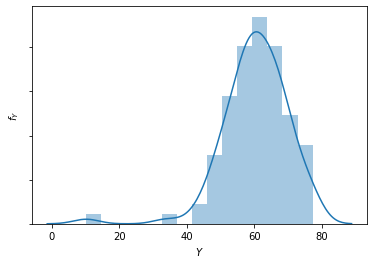

In [89]:
fig, ax = plt.subplots()

sns.distplot(implied_demand)

ax.set_xlabel(r"$Y$")
ax.set_ylabel(r"$f_Y$")

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.axes.get_yaxis().set_ticklabels([])

### Shapley effects for the Rust model
 1. Define functions `rust_model()`, `x_all()`, and `x_cond()`.
 2. Set parameters for `get_shapley()`.
 3. Run `get_shapley()`.

In [96]:
# Define x_all and x_cond. Can use functions from tutorial of Shapley effects and adapt them.
def x_all(n):
    sampled_parameters = cp.MvNormal(mean, cov).sample(n)
    out = np.zeros((n_inputs, n))
    out[:2, :] = sampled_parameters[:2, :]
    out[2, :] = 1- sampled_parameters[0, :] - sampled_parameters[1, :]
    out[3:, :] = sampled_parameters[2:, :]
    return out

In [100]:
test_sample = x_all(10)

In [110]:
# Test whether first elements sum up to one.
np.sum(test_sample[:3, :], axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
def x_cond(n, subset_j, subsetj_conditional, xjc):
    if subsetj_conditional is None:
        cov_int = np.array(cov)
        cov_int = cov_int.take(subset_j, axis = 1)
        cov_int = cov_int[subset_j]
        distribution = cp.MvNormal(mean[subset_j], cov_int)
        return distribution.sample(n)
    else:
        return _r_condmvn(n, mean = mean, cov = cov, dependent_ind = subset_j, given_ind = subsetj_conditional, x_given = xjc)